# Model Evaluation

Notebook to evaluate the Training of our models and compare them to pretrained GPT2. For that, we load the training results and the models and calculate the BLEU score.

---

## Notebook Setup


In [23]:
# install packages
# ! pip install pandas
# ! pip install transformers
# ! pip install seaborn
# ! pip install matplotlib
# ! pip install numpy
# ! pip install evaluate

In [24]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import pipeline
import evaluate

In [27]:
# paths
root = './'
driveFolder = root + 'trainingRuns/TrainRuns-DriveSync/'
runFolder = '22_12_05_Run_05_E15_BS_2_S_7_TopRapBoth/'
trainingBothCsv = driveFolder + runFolder + 'training_stats_both.csv'
trainingRapCsv = driveFolder + runFolder + 'training_stats_rap.csv'
trainingTopCsv = driveFolder + runFolder + 'training_stats_top.csv'
savedModelBoth = driveFolder + runFolder + 'model_save/both/'
savedModelRap = driveFolder + runFolder + 'model_save/rap/'
savedModelTop = driveFolder + runFolder + 'model_save/top/'
testLyricsBoth = root + 'datasets/both_test_samples.csv'
testLyricsRap = root + 'datasets/rap_test_samples.csv'
testLyricsTop = root + 'datasets/top_test_samples.csv'

---

## Load training results

In [28]:
def plot_loss(df, df_description):
   # Plot graph
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (20,6)

    # Plot the learning curve.
    plt.plot(df['Training Loss'], 'b-o', label="Training")
    plt.plot(df['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss for " + df_description)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(np.arange(len(df)))

    return plt

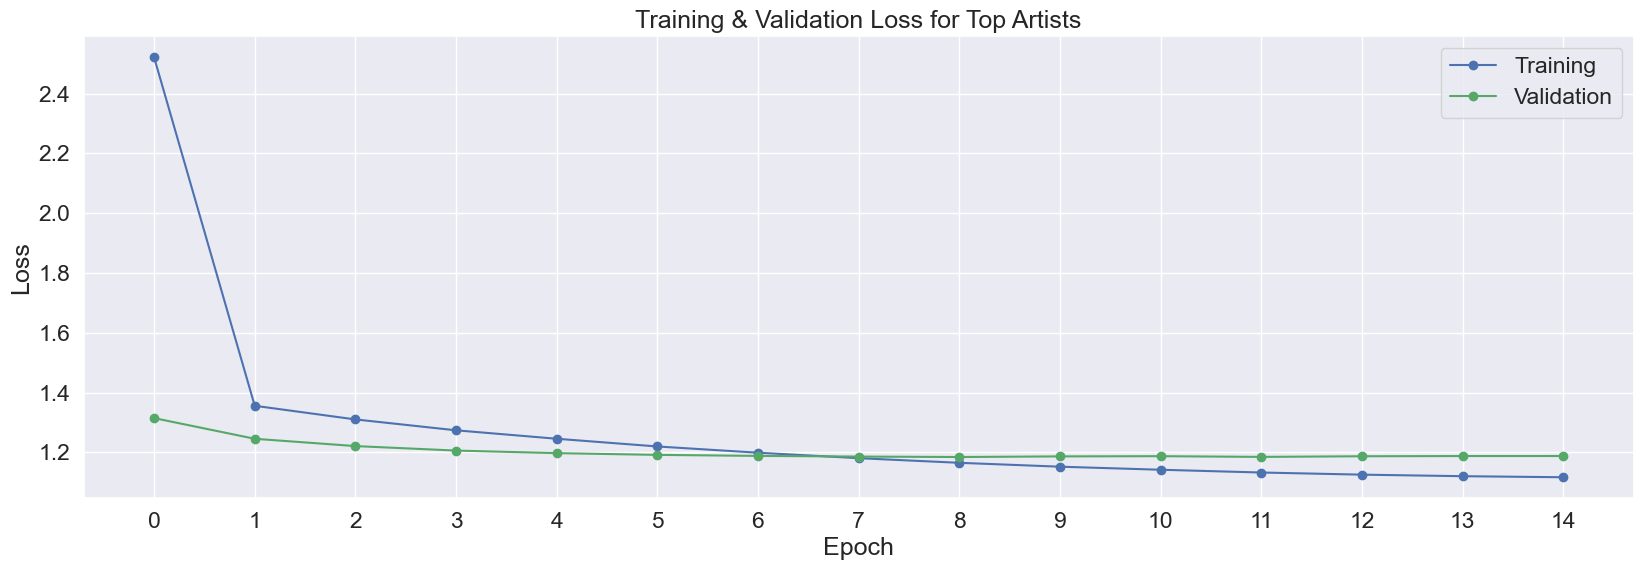

In [29]:
# load trainin.csv
df_stats_top = pd.read_csv(trainingTopCsv)
plt = plot_loss(df_stats_top, 'Top Artists')
plt.show()

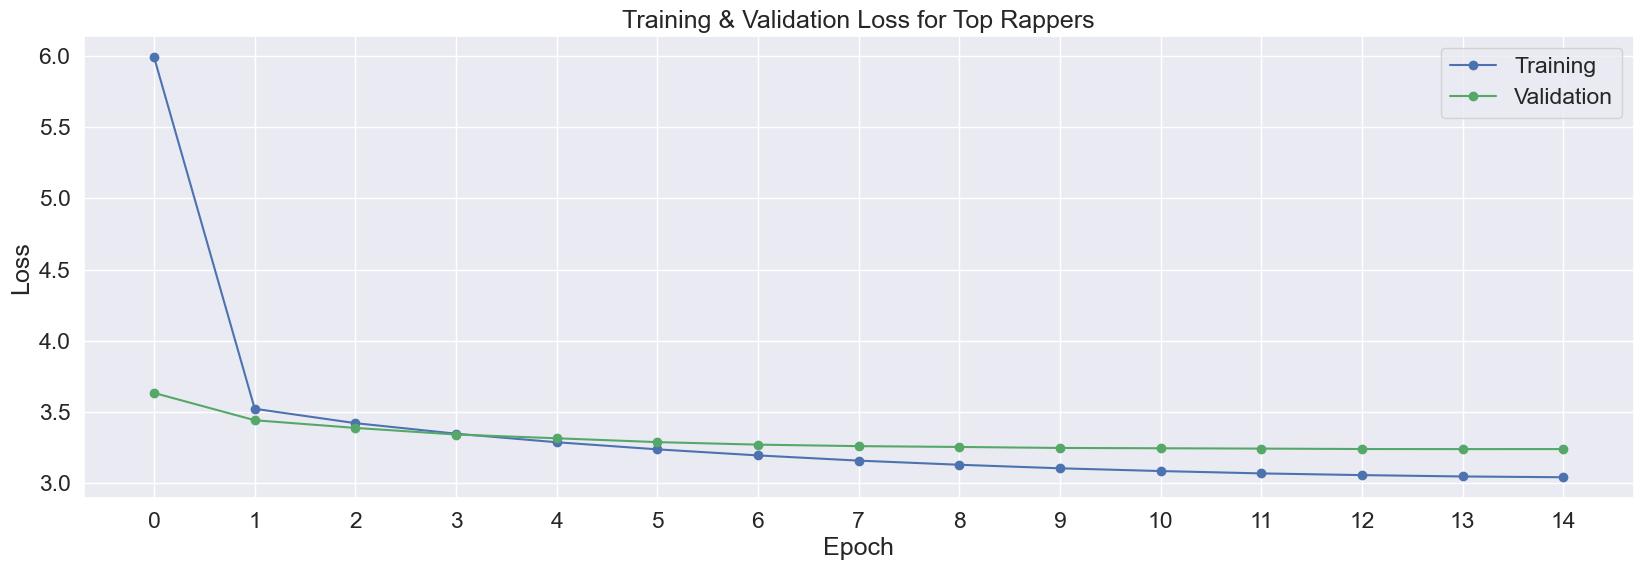

In [30]:
# load trainin.csv
df_stats_rap = pd.read_csv(trainingRapCsv)
plt = plot_loss(df_stats_rap, 'Top Rappers')
plt.show()

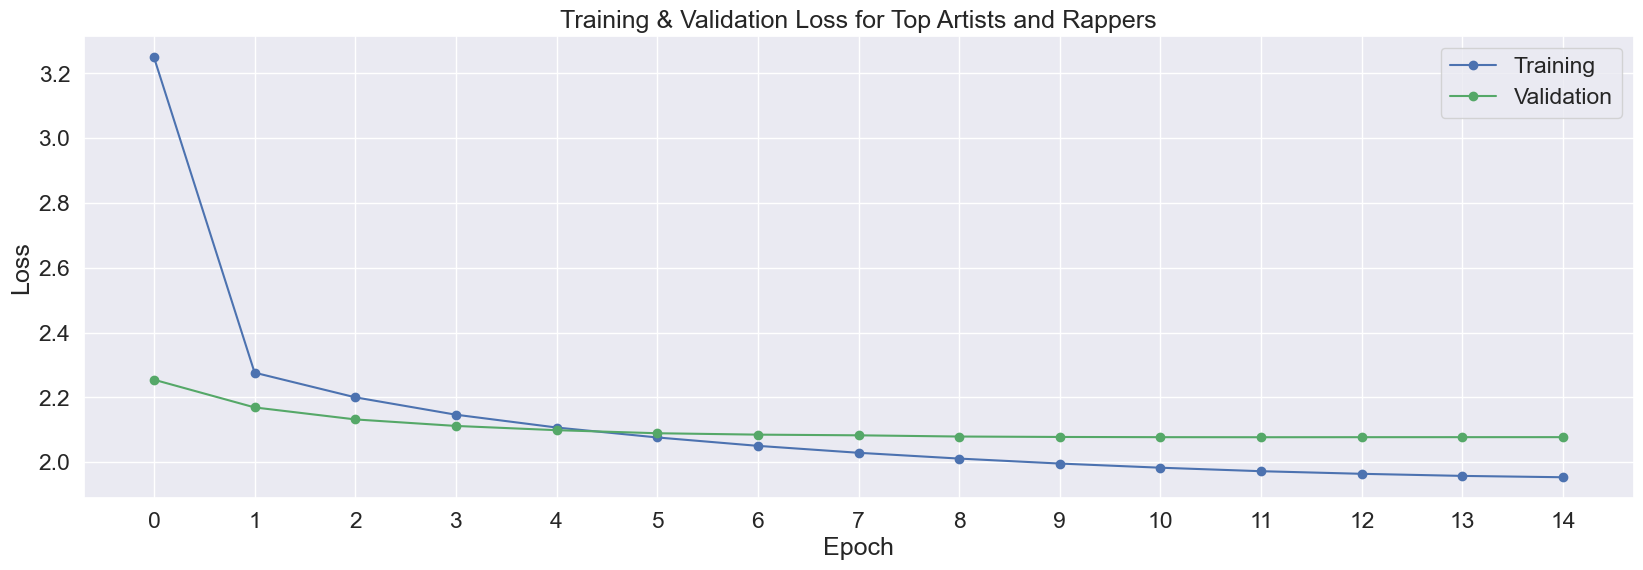

In [31]:
# load trainin.csv
df_stats_both = pd.read_csv(trainingBothCsv)
plt = plot_loss(df_stats_both, 'Top Artists and Rappers')
plt.show()

---

## Load model


### Load trained models

In [32]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') 

#### Top model

In [33]:
# load model from file
model_top = GPT2LMHeadModel.from_pretrained(savedModelTop)
model_top.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

In [34]:
# pipline for text generation
lyrics_pipeline_top = pipeline('text-generation',model=model_top, tokenizer=tokenizer)
song_input = 'can you generate me some songlyrics\n'
#result = lyrics_pipeline_top(song_input, max_length=1024,min_length=512)[0]['generated_text']

#### Rap model

In [35]:
model_rap = GPT2LMHeadModel.from_pretrained(savedModelRap)
model_rap.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

In [36]:
# pipline for text generation
lyrics_pipeline_rap = pipeline('text-generation',model=model_rap, tokenizer=tokenizer)
song_input = 'can you generate me some songlyrics\n'
#result = lyrics_pipeline(song_input, max_length=1024,min_length=512)[0]['generated_text']

#### Both model

In [37]:
model_both = GPT2LMHeadModel.from_pretrained(savedModelBoth)
model_both.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

In [38]:
# pipline for text generation
lyrics_pipeline_both = pipeline('text-generation',model=model_both, tokenizer=tokenizer)
song_input = 'can you generate me some songlyrics\n'
#result = lyrics_pipeline(song_input, max_length=1024,min_length=512)[0]['generated_text']

### Load vanilla gpt2 for comparission

In [39]:
## load vanilla GPT2 from huggingface
modelGPT2 = GPT2LMHeadModel.from_pretrained('gpt2')
modelGPT2.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

In [40]:
# pipline for text generation
gpt_pipeline = pipeline('text-generation',model=modelGPT2, tokenizer=tokenizer)
song_input = 'can you generate me some songlyrics\n'
#gpt2Result = gpt_pipeline(song_input, max_length=1024,min_length=512)[0]['generated_text']

---

## Calculate BLEU score

In [41]:
def generate_evaluation_data(test_df, generation_pipeline, tokenizer):
    predictions = []
    references = []

    for row in test_df.iterrows():
        lyrics_original = row[1][0]
        lyrics_true_end = row[1][1]
        lyrics_cut = row[1][2]

        # Append original end
        references.append(lyrics_true_end)

        # Find out how many tokens to generate
        tokenized_lyric = tokenizer(lyrics_original, truncation=True)
        output_length = len(tokenized_lyric['input_ids'])

        # Generate Song lyrics based on cutted lyrics
        result = generation_pipeline(lyrics_cut, max_length=output_length, min_length=output_length)[0]['generated_text']

        # Slice of the generated part
        result = result.replace(lyrics_cut, "")
        # remove first whitespace
        result = result[1:]
        # Append generated end
        predictions.append(result)
    
    return predictions, references

In [49]:
# Compare gpt-vanilla to top
testLyricsTop_df = pd.read_csv(testLyricsTop)
testLyricsTop_df = testLyricsTop_df.drop(['Unnamed: 0'], axis=1)

#testLyricsTop_df = testLyricsTop_df.drop(testLyricsTop_df.index[5:])
testLyricsTop_df = testLyricsTop_df.dropna()

for row in testLyricsTop_df.iterrows():
    if len(row[1][2]) > 3619:
        testLyricsTop_df = testLyricsTop_df.drop([row[0]])

pred_model_top, ref_model_top = generate_evaluation_data(testLyricsTop_df, lyrics_pipeline_top, tokenizer)
pred_model_gpt2_top, ref_model_gpt2_top = generate_evaluation_data(testLyricsTop_df, gpt_pipeline, tokenizer)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [ ]:
# Compare gpt-vanilla to rap
testLyricsRap_df = pd.read_csv(testLyricsRap)
testLyricsRap_df = testLyricsRap_df.drop(['Unnamed: 0'], axis=1)

#testLyricsRap_df = testLyricsRap_df.drop(testLyricsRap_df.index[5:])
testLyricsRap_df = testLyricsRap_df.dropna()

for row in testLyricsRap_df.iterrows():
    if len(row[1][2]) > 3619:
        testLyricsRap_df = testLyricsRap_df.drop([row[0]])


pred_model_rap, ref_model_rap = generate_evaluation_data(testLyricsRap_df, lyrics_pipeline_rap, tokenizer)
pred_model_gpt2_rap, ref_model_gpt2_rap = generate_evaluation_data(testLyricsRap_df, gpt_pipeline, tokenizer)

In [ ]:

testLyricsBoth_df = pd.read_csv(testLyricsBoth)
testLyricsBoth_df = testLyricsBoth_df.drop(['Unnamed: 0'], axis=1)

#testLyricsBoth_df = testLyricsBoth_df.drop(testLyricsBoth_df.index[5:])
testLyricsBoth_df = testLyricsBoth_df.dropna()

''
for row in testLyricsBoth_df.iterrows():
    if len(row[1][2]) > 3619:
        testLyricsBoth_df = testLyricsBoth_df.drop([row[0]])
        
pred_model_both, ref_model_both = generate_evaluation_data(testLyricsBoth_df, lyrics_pipeline_both, tokenizer)
pred_model_gpt2_both, ref_model_gpt2_both = generate_evaluation_data(testLyricsBoth_df, lyrics_pipeline_both, tokenizer)

---

In [51]:
bleu = evaluate.load("bleu")

#### Top model vs gpt vanilla

In [52]:
results_top = bleu.compute(predictions=pred_model_top, references=ref_model_top)
results_gpt_top = bleu.compute(predictions=pred_model_gpt2_top, references=ref_model_gpt2_top)

In [53]:
print(results_top)
print(results_gpt_top)

{'bleu': 0.06990991404765143, 'precisions': [0.2456283667791393, 0.0664547543364644, 0.0430868321181865, 0.03396299105476698], 'brevity_penalty': 1.0, 'length_ratio': 1.1838287852667873, 'translation_length': 84465, 'reference_length': 71349}
{'bleu': 0.06998259732665302, 'precisions': [0.23481349911190053, 0.0651810025443021, 0.04346899398725657, 0.03605259596734178], 'brevity_penalty': 1.0, 'length_ratio': 1.26252645447028, 'translation_length': 90080, 'reference_length': 71349}


#### Rap model vs gpt vanilla

In [ ]:
results_rap = bleu.compute(predictions=pred_model_rap, references=ref_model_rap)
results_gpt_rap = bleu.compute(predictions=pred_model_gpt2_rap, references=ref_model_gpt2_rap)

NameError: name 'pred_model_rap' is not defined

In [ ]:
print(results_rap)
print(results_gpt_rap)

#### Both model vs gpt vanilla

In [ ]:
results_both = bleu.compute(predictions=pred_model_both, references=ref_model_both)
results_gpt_both = bleu.compute(predictions=pred_model_gpt2_both, references=ref_model_gpt2_both)

In [ ]:
print(results_both)
print(results_gpt_both)

---